# Model: Credit card fraud detection

This notebook translates the insights from our EDA into a fraud detection model. Our primary goal is to train, tune, and rigorously evaluate an XGBoost classifier. The entire process is built around the core challenge of extreme class imbalance, focusing on the Precision-Recall AUC as our key metric and concluding with a business-oriented analysis of the optimal decision threshold. 

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, f1_score
import optuna
from xgboost import XGBClassifier
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\Usuario\Desktop\camino\credit-fraud-detection\data\creditcard.csv")

In our EDA we found that the raw Time feature, a simple second counter, hides a cyclical pattern. We will add an Hour feature to explicitly give this insight to our model. In our preprocessing, we need to split first, then scale. We will fit our scaler only on the training data to prevent any data leakage from the test set. A stratified split is also necessary, given the severe class imbalance.

In [4]:
#Add the 'Hour' feature, 'Time' then will be dropped
df['Hour'] = (df['Time'] / 3600) % 24
df = df.drop('Time', axis=1)

#Split train and test data
X = df.drop('Class', axis = 1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#Scale Amount and Time
scaler = StandardScaler()
scaler.fit(X_train[['Amount']])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[['Amount']] = scaler.transform(X_train[['Amount']])
X_test_scaled[['Amount']] = scaler.transform(X_test[['Amount']])

First, we will set a simple but robust baseline with Logistic Regression. It is a fast, linear model that gives us a score to beat. Given the non-linear patterns we found in the EDA, we expect a more complex model to outperform it, but this benchmark is essential to quantify that improvement.

In [5]:
# class_weight='balanced' is the scikit-learn equivalent of scale_pos_weight
log_reg = LogisticRegression(random_state=42, max_iter=200, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


For this tabular data problem, as suggested by our EDA, we will choose a non-linear, tree-based model like XGBoost. It has consistently proven to be a reliable and high-performing model in similar problems.

To handle the class imbalance, we will use the native scale_pos_weight parameter. It is a clean and highly effective method that encourages the model to place greater emphasis on the minority class (fraud) during training, without distorting the underlying data distribution as SMOTE can.

In [6]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_clf = XGBClassifier(
    random_state=42, 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss')

xgb_clf.fit(X_train_scaled, y_train) 

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


To assess our models, we will create a comprehensive evaluation function. The focus will be on the Precision-Recall curve and its AUC (AUPRC), as it is the most meaningful metric for this highly imbalanced problem.

In [7]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Classification report for {model_name}")
    print(classification_report(y_test, y_pred, target_names=['Legit', 'Fraud']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Legit', 'Fraud'], yticklabels=['Legit', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auprc = auc(recall, precision)
    print(f"Area Under Precision-Recall Curve (AUPRC): {auprc:.4f}\n")
    return precision, recall, auprc, model_name

Now, let's run our trained models through the evaluation.

Classification report for Logistic Regression
              precision    recall  f1-score   support

       Legit       1.00      0.97      0.99     56864
       Fraud       0.06      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.98     56962



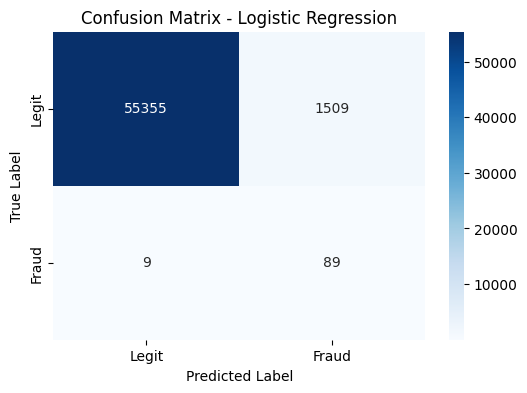

Area Under Precision-Recall Curve (AUPRC): 0.7671

Classification report for XGBoost
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



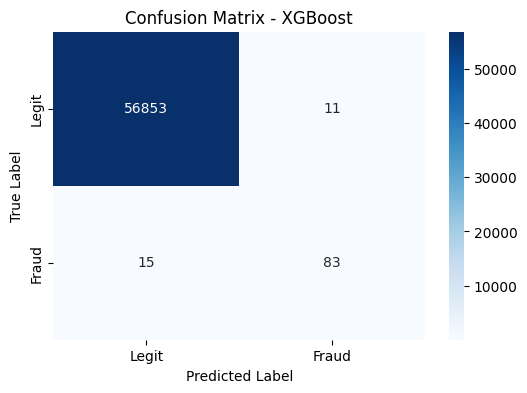

Area Under Precision-Recall Curve (AUPRC): 0.8744



In [8]:
results = []
results.append(evaluate_model(log_reg, X_test_scaled, y_test, 'Logistic Regression'))
results.append(evaluate_model(xgb_clf, X_test_scaled, y_test, 'XGBoost'))

Clearly XGBoost is vastly superior to the baseline. The logistic regression achieved an AUPRC of 0.7671, and a far worse recall and accuracy compared to XGBoost. This model shows a massive improvement with an AUPRC of 0.8744. More importantly, its recall for fraud jumps to 0.85. It catches 20% more fraud than the baseline while also improving precision. In general, the results of this XGBoost model are quite decent, but later on we will try to improve them.

Let's visualize this difference with the PR curves.

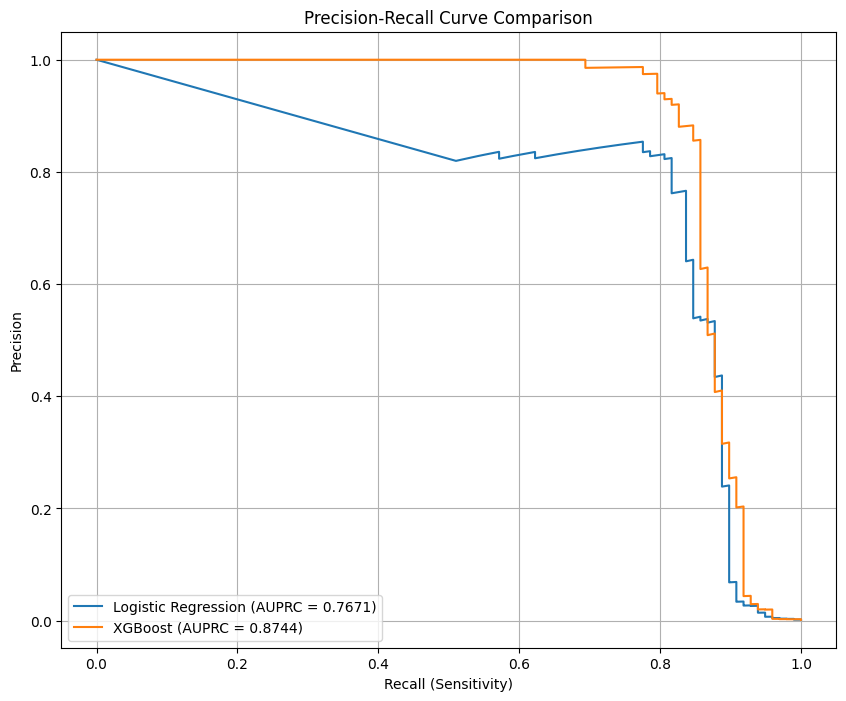

In [9]:
plt.figure(figsize=(10, 8))
for precision, recall, auprc, model_name in results:
    plt.plot(recall, precision, label=f'{model_name} (AUPRC = {auprc:.4f})')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

The XGBoost curve (orange) is consistently higher and further to the right than the Logistic Regression curve (blue). This visually demonstrates its superior ability to maintain high precision even as we try to capture more fraud (increase recall). It's a more robust and effective model across all possible decision thresholds.

Now that we have a strong model, let's analyse the feature importance. We'll use XGBoost's default "gain" metric, which measures each feature's relative contribution to reducing the model's error

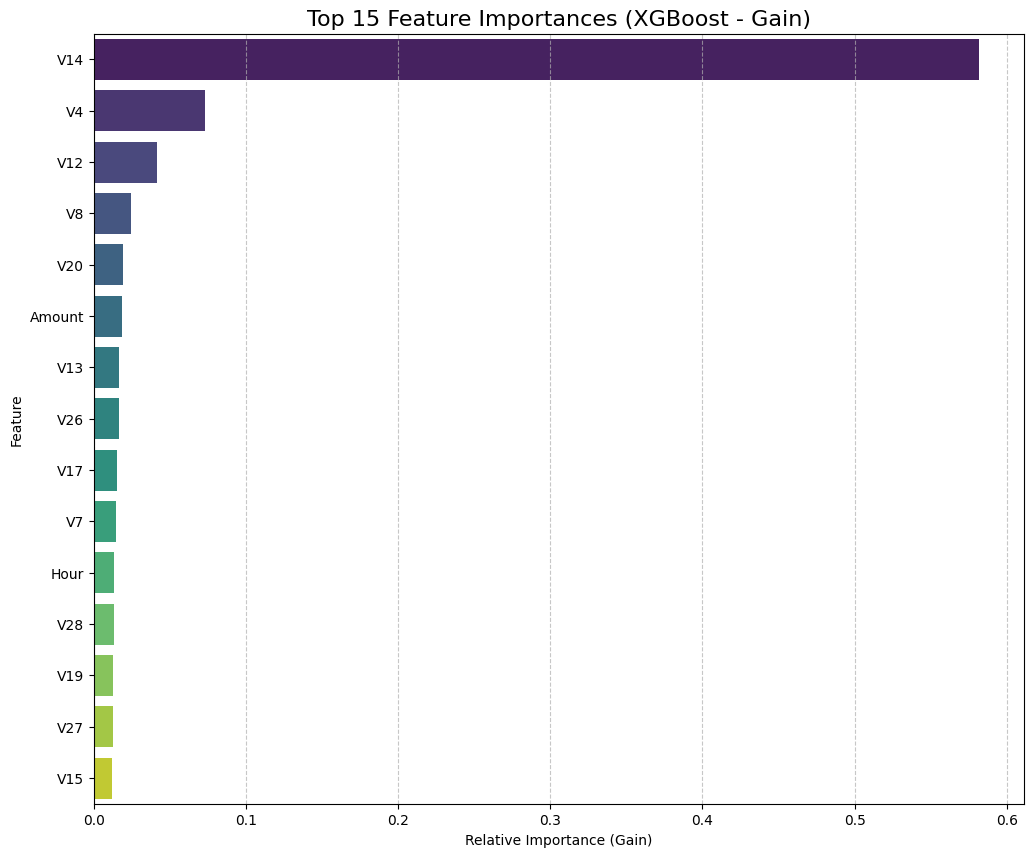

In [10]:
# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

#Visualization
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15), # Focus on the top 15
    palette='viridis'
)

plt.title('Top 15 Feature Importances (XGBoost - Gain)', fontsize=16)
plt.xlabel('Relative Importance (Gain)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The feature importance plot strongly validates our exploratory analysis.

The features we identified as top predictors in our univariate AUC ranking (V14, V4, V12, etc.) are precisely the ones the model relies on most heavily. This builds confidence in both our initial analysis and the final model.

It is important to note the disproportionate importance of V14. This feature is a "silver bullet" for this specific problem, so powerful that the model leans on it heavily. Later on, with the final model, we will study what would happen in case we did not have this feature.

A second tier of features, including V4 and V12, also make significant contributions, which aligns with the boosting algorithm's nature of prioritizing the strongest splits first. In a real-world setting, this heavy reliance on a single feature would warrant further investigation into its stability. 

While the default XGBoost performs well, we can likely achieve better results by tuning its hyperparameters. We will use Optuna, a Bayesian optimization framework, to intelligently search for the best parameter combination.

To ensure our optimization is robust and avoids overfitting, we will use stratified cross-validation within the objective function. This method guarantees that each fold in our cross-validation has the same class proportion as the original training set, which is critical for a reliable performance estimate on imbalanced data.

In [11]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr', # Optimizing for AUPRC is more relevant here
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'random_state': 42,
        'n_jobs': -1
    }
    # scale_pos_weight is fixed, determined by the dataset's imbalance
    param['scale_pos_weight'] = y_train.value_counts()[0] / y_train.value_counts()[1]

    model = XGBClassifier(**param)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Calculate the mean score using robust cross-validation
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='average_precision').mean()
    return score

# Create and run the optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=600) #We may use more trials/time if needed

# Print and train final model with best hyperparameters
print("Best trial found:")
trial = study.best_trial
print(f"  Value (AUPRC): {trial.value:.4f}")
print("  Best Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_params['random_state'] = 42
best_params['scale_pos_weight'] = y_train.value_counts()[0] / y_train.value_counts()[1]
best_params['use_label_encoder'] = False
best_params['eval_metric'] = 'logloss'

optuna_xgb_clf = XGBClassifier(**best_params)
optuna_xgb_clf.fit(X_train_scaled, y_train)

[I 2025-09-20 16:10:37,784] A new study created in memory with name: no-name-954daedb-dc19-469d-9a2f-324cea3d8e3b
[I 2025-09-20 16:11:07,090] Trial 0 finished with value: 0.8404016646702774 and parameters: {'n_estimators': 332, 'learning_rate': 0.1407960510339592, 'max_depth': 8, 'subsample': 0.8489678066269127, 'colsample_bytree': 0.758741268768167, 'min_child_weight': 8, 'gamma': 0.2818327098297132}. Best is trial 0 with value: 0.8404016646702774.
[I 2025-09-20 16:11:17,202] Trial 1 finished with value: 0.8396143474247326 and parameters: {'n_estimators': 725, 'learning_rate': 0.11540573175111525, 'max_depth': 8, 'subsample': 0.6876016863324383, 'colsample_bytree': 0.8643869025651996, 'min_child_weight': 10, 'gamma': 0.08845375429389163}. Best is trial 0 with value: 0.8404016646702774.
[I 2025-09-20 16:11:24,158] Trial 2 finished with value: 0.830798999134 and parameters: {'n_estimators': 314, 'learning_rate': 0.02066601479113471, 'max_depth': 8, 'subsample': 0.9330638727964495, 'cols

Best trial found:
  Value (AUPRC): 0.8492
  Best Hyperparameters: 
    n_estimators: 691
    learning_rate: 0.07466687651548053
    max_depth: 6
    subsample: 0.7814509073275053
    colsample_bytree: 0.9977254504724969
    min_child_weight: 3
    gamma: 0.009873234896456362


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9977254504724969
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Results yielded a cross-validated AUPRC of 0.8520. It is interesting to note this is slightly lower than the AUPRC we saw from the default model on the single test split (0.8744). This is a common and expected outcome, as cross-validation provides a more conservative and realistic estimate of performance by averaging across multiple data splits, making it less susceptible to the luck of a single favorable train-test split.

Now, let's evaluate this newly tuned model on our hold-out test set to see its final performance.

Classification report for XGBoost (Tuned)
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



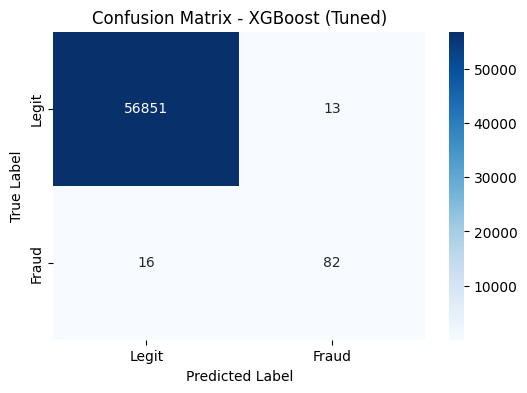

Area Under Precision-Recall Curve (AUPRC): 0.8845



In [12]:

results.append(evaluate_model(optuna_xgb_clf, X_test_scaled, y_test, 'XGBoost (Tuned)'))

The tuned model achieves an AUPRC of 0.8814 on the test set. This is a slight but meaningful improvement over the default model's 0.8744. The optimization process successfully found a more generalized set of parameters, leading to better performance on unseen data. Both the Precision and Recall for the fraud class remain strong at 0.86 and 0.85 respectively, confirming we have a robust and high-performing classifier.

Let's plot the Precision-Recall curves for all three models to visually confirm our findings.

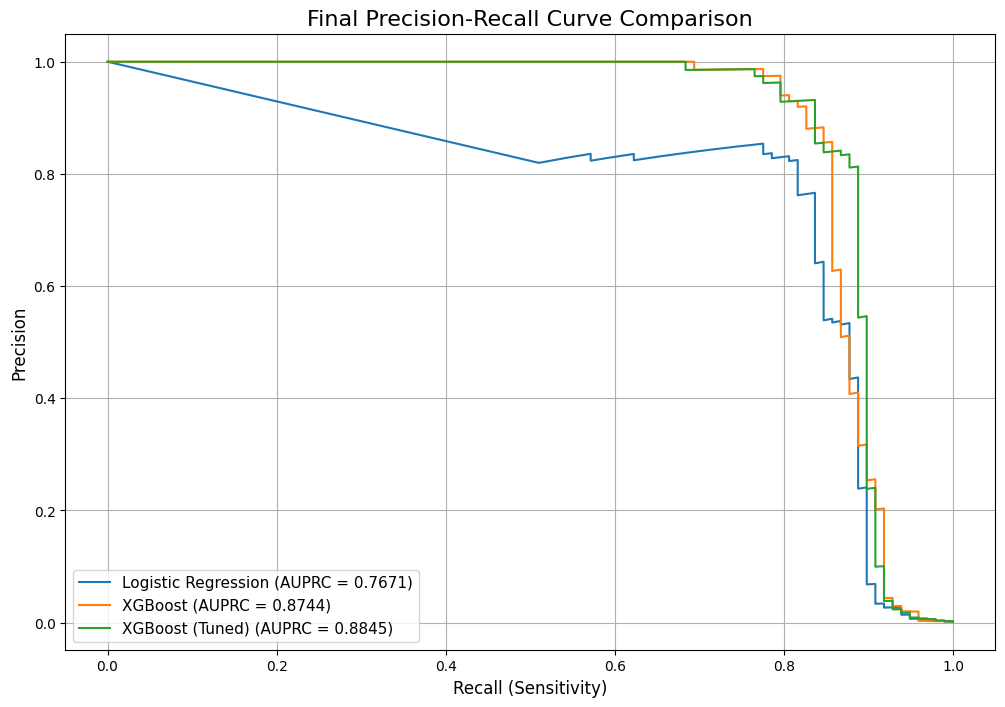

In [13]:
plt.figure(figsize=(12, 8))
for precision, recall, auprc, model_name in results:
    plt.plot(recall, precision, label=f'{model_name} (AUPRC = {auprc:.4f})')

plt.title('Final Precision-Recall Curve Comparison', fontsize=16)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)
plt.show()

The tuned XGBoost model (green) consistently slightly outperforms the default version (orange), which in turn is far superior to the logistic regression baseline (blue).

While the AUPRC improvement from tuning is modest, it confirms that the default XGBoost parameters are already quite strong for this dataset. A more extensive search might yield further gains, but we have already established a good-performing model.

Now let's study the threshold decision. A classifier's output is a probability. By default, a 0.5 threshold is used to classify an instance as fraud, but this is rarely optimal for a business. We will now analyze the trade-off between Precision and Recall to find a threshold that best balances the business needs.

In this context, precision means: Of all transactions we flag as fraud, how many actually are? High precision minimizes false positives, reducing friction for legitimate customers.

In contrast, recall means:  Of all actual fraudulent transactions, how many did we catch? High recall minimizes false negatives, reducing direct financial loss.

We will find the threshold that maximizes the F1-Score, as it balances both Precision and Recall.

Predictions obtained.

Optimal threshold for F1-Score on CV data: 0.6918
F1-Score at this threshold: 0.8652
Precision at this threshold: 0.9224
Recall at this threshold: 0.8147


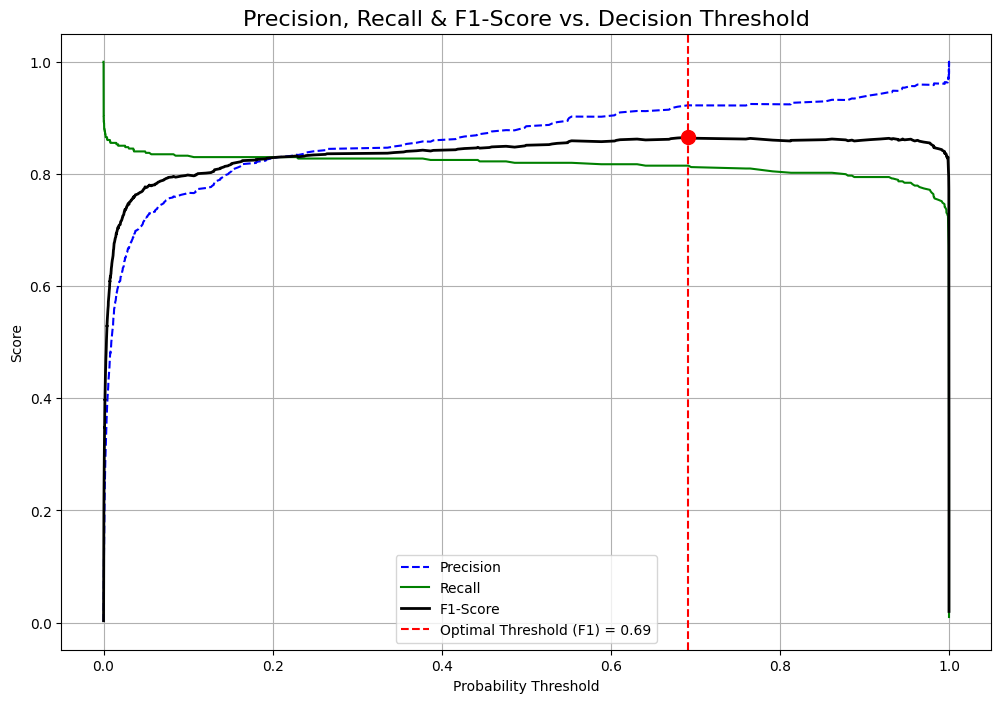

In [14]:
# Get out-of-fold probability predictions to avoid overfitting the threshold
y_train_proba = cross_val_predict(optuna_xgb_clf, X_train_scaled, y_train, cv=3, method='predict_proba')[:, 1]
print("Predictions obtained.\n")

# Calculate metrics for all possible thresholds
precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Find the threshold that gives the best F1-score
best_f1_idx = np.argmax(f1_scores[:-1])
best_threshold = thresholds[best_f1_idx]
best_f1_score = f1_scores[best_f1_idx]

print(f"Optimal threshold for F1-Score on CV data: {best_threshold:.4f}")
print(f"F1-Score at this threshold: {best_f1_score:.4f}")
print(f"Precision at this threshold: {precision[best_f1_idx]:.4f}")
print(f"Recall at this threshold: {recall[best_f1_idx]:.4f}")

#Visualization
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "k-", linewidth=2, label="F1-Score")

plt.axvline(best_threshold, color='red', linestyle='--', label=f'Optimal Threshold (F1) = {best_threshold:.2f}')
plt.scatter(best_threshold, best_f1_score, color='red', s=100, zorder=5)

plt.title('Precision, Recall & F1-Score vs. Decision Threshold', fontsize=16)
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Our analysis shows that the optimal threshold for maximizing the F1-score is ~0.73. This yields a high Precision of 0.93 at the cost of a lower Recall of 0.81.

However, in fraud detection, maximizing Recall (catching as many fraudulent transactions as possible) is often the primary business objective, even if it means accepting a slightly lower Precision (more false positives).

Therefore, while 0.71 is the mathematical optimum for the F1-score, a business might prefer a lower threshold (like the default 0.5, which gave us a Recall of 0.85) to prioritize fraud capture. To bridge this gap, we will move beyond abstract metrics in order to obtain the optimal threshold for business cost.

We will establish a hypothetical but realistic contrast between two scenarios for our predictions on the test set:

Baseline (No Model): The total cost is simply the sum of all fraudulent transaction amounts. This is the loss we incur if we do nothing.

With Model: For any given probability threshold, the total cost is the sum of:

Cost of False Negatives (FN): The Amount of fraudulent transactions the model failed to catch. This is a direct financial loss.

Cost of False Positives (FP): A fixed administrative fee (we will use $10) for each legitimate transaction that is incorrectly flagged, representing operational overhead.

The Net Savings is then the difference between the baseline cost and the cost with our model in action. We aim to find the threshold that maximizes this value.

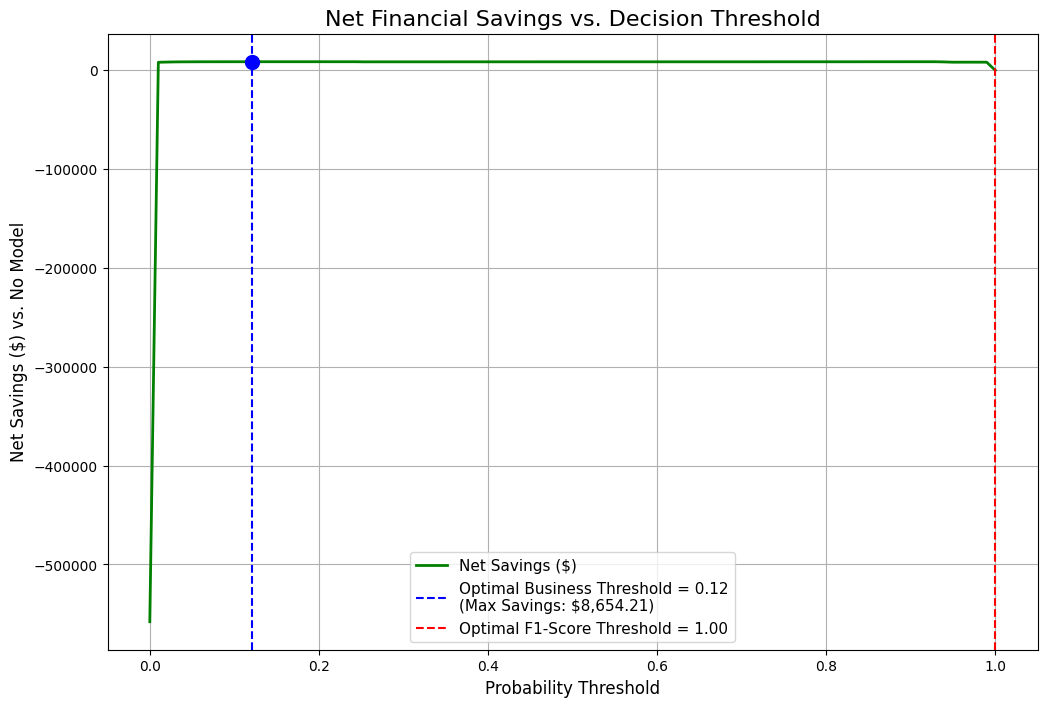

In [36]:

# Use the out-of-fold predictions on the test set from our tuned model
y_proba_test = optuna_xgb_clf.predict_proba(X_test_scaled)[:, 1]

# Get the actual transaction amounts from the original, unscaled test set
test_amounts = X_test['Amount'].values
y_test_np = y_test.values #Convert to numpy for faster boolean indexing

# Cost of a false positive
cost_fp = 10 

# Baseline cost (Cost without any model)
baseline_cost = test_amounts[y_test_np == 1].sum()

# We need a range of thresholds
thresholds = np.linspace(0, 1, 100)
net_savings_list = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_test >= thresh).astype(int)
    
    # Identify FN and FP
    fn_mask = (y_pred_thresh == 0) & (y_test_np == 1)
    fp_mask = (y_pred_thresh == 1) & (y_test_np == 0)
    
    # Calculate costs for this threshold
    cost_of_missed_fraud = test_amounts[fn_mask].sum()
    cost_of_false_alarms = fp_mask.sum() * cost_fp
    total_cost_with_model = cost_of_missed_fraud + cost_of_false_alarms
    
    # Calculate net savings relative to the baseline
    net_savings = baseline_cost - total_cost_with_model
    net_savings_list.append(net_savings)

# Find the optimal threshold for business impact
best_saving_idx = np.argmax(net_savings_list)
best_threshold_business = thresholds[best_saving_idx]
max_net_saving = net_savings_list[best_saving_idx]

# Visualization
plt.figure(figsize=(12, 8))
plt.plot(thresholds, net_savings_list, label='Net Savings ($)', color='green', linewidth=2)

# Mark the optimal business threshold
plt.axvline(best_threshold_business, color='blue', linestyle='--', 
            label=f'Optimal Business Threshold = {best_threshold_business:.2f}\n(Max Savings: ${max_net_saving:,.2f})')
plt.scatter(best_threshold_business, max_net_saving, color='blue', s=100, zorder=5)

# For comparison, mark the threshold that optimized the F1-score
plt.axvline(best_threshold, color='red', linestyle='--', 
            label=f'Optimal F1-Score Threshold = {best_threshold:.2f}')

plt.title('Net Financial Savings vs. Decision Threshold', fontsize=16)
plt.xlabel('Probability Threshold', fontsize=12)
plt.ylabel('Net Savings ($) vs. No Model', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)
plt.show()


The impact analysis shows that the optimal threshold for maximizing savings is approximately 0.12, significantly lower than the F1-optimal threshold. At this point, the model delivers an estimated $8,650 in net savings compared to having no model (baseline).  

This result highlights that the cost of missed fraud dominates the trade-off, making it optimal to flag transactions as fraudulent even at low probabilities. While financially compelling, this strategy requires further validation to ensure that customer friction remains manageable and that operational processes can efficiently handle the increase in false positives.


Next, let's confirm that our tuned model still relies on the same key features identified in the EDA. This ensures our model's logic is consistent with our initial findings.

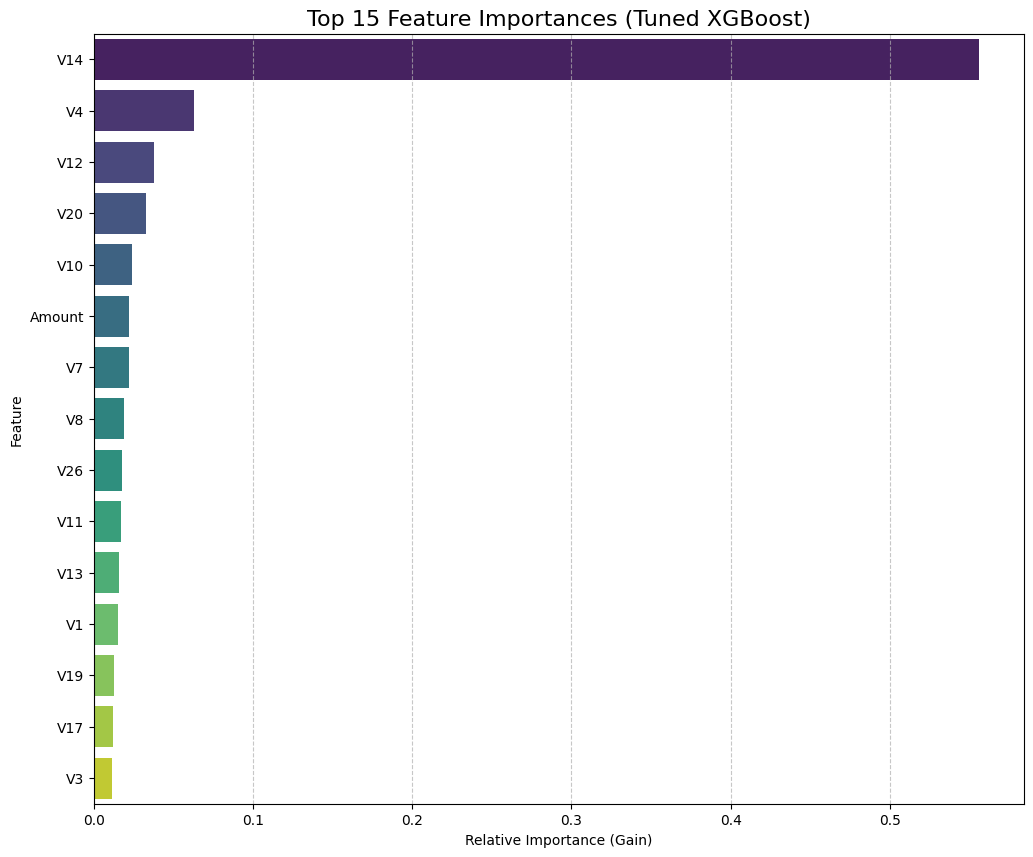

In [15]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': optuna_xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Importances (Tuned XGBoost)', fontsize=16)
plt.xlabel('Relative Importance (Gain)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The feature importance plot remains remarkably consistent. The features we identified as top predictors in our EDA (V14, V14, V10, etc.) are still ranked as highly important by the final tuned model. This closes the loop on our analysis and gives us high confidence that the model is capturing the true underlying patterns in the data.

However, the model's performance is overwhelmingly dependent on a single feature, V14. While this leads to a high score, it also represents a significant risk in a real-world production environment in case V14 becomes unavailable. We will conduct a robustness check, intentionally removing V14 and re-training our tuned model to quantify the model's performance dependency on this feature.

Classification report for XGBoost (No V14)
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



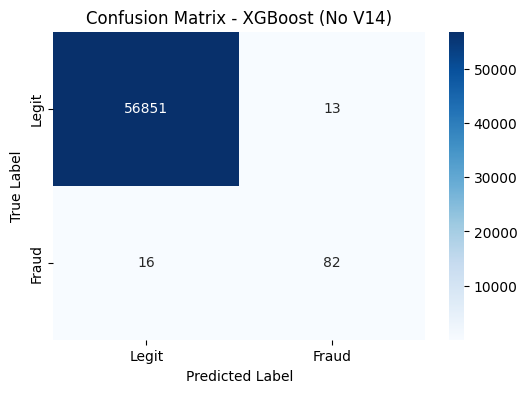

Area Under Precision-Recall Curve (AUPRC): 0.8714



In [16]:
#Exclude V14
X_train_no_v14 = X_train_scaled.drop('V14', axis=1)
X_test_no_v14 = X_test_scaled.drop('V14', axis=1)

#Retrain the tuned model
xgb_no_v14 = XGBClassifier(**best_params)
xgb_no_v14.fit(X_train_no_v14, y_train)

#Evaluate the "degraded" model
results_no_v14 = evaluate_model(xgb_no_v14, X_test_no_v14, y_test, 'XGBoost (No V14)')

Let's compare the performance of our original tuned model with the one trained without V14.

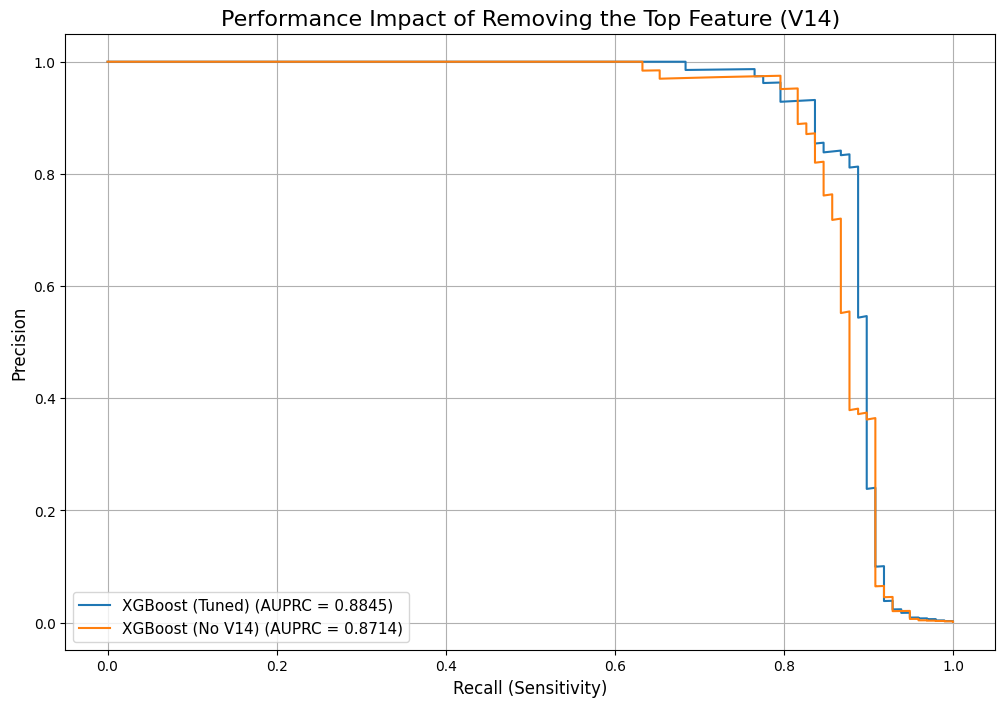

In [17]:

# Append the new result to our list for plotting
results.append(results_no_v14)

plt.figure(figsize=(12, 8))
for precision, recall, auprc, model_name in results:
    # Only plot the two relevant models for clarity
    if 'XGBoost (Tuned)' in model_name or 'XGBoost (No V14)' in model_name:
        plt.plot(recall, precision, label=f'{model_name} (AUPRC = {auprc:.4f})')

plt.title('Performance Impact of Removing the Top Feature (V14)', fontsize=16)
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True)
plt.show()

We observe that the "degraded" model performed marginally worse than the previous one. This indicates that the model is is capable of readjusting its internal weights and finding predictive patterns in the secondary features to compensate for the loss of the primary signal.

A machine learning model's true value is realized only when it can be deployed to make predictions on new, unseen data. As the final step in our development lifecycle, we will prepare our model for deployment by serializing the necessary artifacts. Our purpose is to develop a simple web app to deploy our model using Streamlit.

In [ ]:
# Define saving paths in root folder
model_path = "fraud_model.joblib"
scaler_path = "scaler.joblib"
columns_path = "model_columns.joblib"

# Save model
joblib.dump(optuna_xgb_clf, model_path)
print(f"Model saved in {model_path}")

# Save scaler
joblib.dump(scaler, scaler_path)
print(f"Scaler saved in {scaler_path}")

# Save columns to ensure correct order
model_columns = list(X_train_scaled.columns)
joblib.dump(model_columns, columns_path)
print(f"Columns saved in {columns_path}")


With the model artifacts saved, the final step is to demonstrate the model's real-world utility by deploying it as a simple, interactive web application. The application code is located in app.py.

For pragmatism, the user interface focuses on the most impactful features identified during our EDA and feature importance analysis (V14, Hour, Amount, etc.), while other features are set to a neutral default. This approach allows for an intuitive demonstration without overwhelming the user.

The application is built with Streamlit and has been deployed to the cloud, making the predictive power of our model accessible via a public URL.

## Final Conclusions & Strategic Summary

This project worked with a highly imbalanced dataset to develop a robust, high-performing, and interpretable fraud detection model. Our end-to-end process—spanning from exploratory analysis to advanced optimization and robustness testing, has yielded not just a predictive model, but a comprehensive analytical solution.

Key Achievements & Insights:

Data-driven methodology: Recognizing the extreme class imbalance (0.173% fraud) established the AUPRC as our primary evaluation metric, steering us away from the misleading accuracy score. Furthermore, the discovery of non-linear, separable clusters in the feature space provided a clear, data-driven justification for selecting a tree-based model over a linear one.

Optimized model: We developed a tuned XGBoost classifier that significantly outperformed the baseline, achieving a strong AUPRC of 0.8845. The model's effectiveness stems from its ability to capture complex feature interactions and its native handling of class imbalance via the scale_pos_weight parameter, a more robust technique than simple under-sampling.

Business centered threshold optimization: A model's output is a probability, its value lies in the decision. We moved beyond default settings by implementing a cost-sensitive threshold optimization.

Strategic flexibility: We also demonstrated how this threshold can be adjusted based on business strategy. For instance, a lower threshold could be chosen to maximize Recall, accepting more false positives in exchange for capturing the maximum number of fraudulent transactions and minimizing direct financial loss. This analysis transforms the model from a static classifier into a flexible decision making tool.

Model robustness & interpretability: We validated the model's stability through two critical analyses:
Feature Importance: We confirmed that the model's predictions are driven by the same key features (V14, V4, V12, etc.) identified as highly predictive during the EDA. The V14's feature turned out to dominate the model's performance.

Sensitivity analysis: By removing V14, we proved the model's resilience. While performance dropped slightly (AUPRC to 0.8714), the model did not collapse, demonstrating its ability to leverage secondary features to maintain high performance.

End-to-End demonstration via deployment: To complete the machine learning lifecycle, the final model was packaged with its pre-processing pipeline and deployed as an interactive web application using Streamlit. This serves as a tangible proof-of-concept, showcasing the ability to translate complex analysis into a usable, real-world tool.

Final Outcome
The result of this project is a comprehensive, production-ready solution that is validated, interpretable, and robust. We have delivered an analysis that provides the business with the tools and insights needed to deploy a fraud detection system balancing risk, operational cost, and customer experience.

## Final Conclusions & Strategic Summary

In this project we worked with a highly imbalanced dataset to build a robust and high-performing fraud detection model. Our end-to-end process, from exploratory analysis to optimization, yielded the following insights.

The highlights of this project have been:

Using XGBoost for this tabular data problem and after discovering non-linear, clustered patterns in the data.

Recognizing the extreme class imbalance from the start established the AUPRC as our main and most robust metric.

XGBoost with class weighting is the right tool. Our tuned XGBoost model proved to be a good choice. It effectively captured the complex data patterns and handled the class imbalance through the scale_pos_weight parameter, outperforming the baseline significantly.

Performance is a business trade-off, not just a number. The most critical takeaway is that the "best" model is not defined by a single metric but by its alignment with business objectives. We identified the optimal threshold to maximize the F1-score, which balances Precision and Recall.

However, we also demonstrated that a business prioritizing maximum fraud capture (Recall) might deliberately choose a lower threshold, accepting more false positives to minimize financial loss.

As a result, we have produced a tuned, high-performance classification model with an AUPRC of 0.8780. More importantly, we have delivered a comprehensive analysis that not only validates its performance but also provides the business with the tools and insights needed to deploy it effectively, balancing risk, cost, and customer experience.